In [13]:
def get_current_dir():
    import os
    from pathlib import Path
    try:
        return Path(__file__).parent.absolute()
    except NameError:
        return Path(os.getcwd())

results = get_current_dir().parent / "data" / "results.csv"
results_authors = get_current_dir().parent / "data" / "results-authors.csv"

"""
i have attempted to reproduce results from a paper. i had to guess some missing hyperparameters.

i want to conduct statistical tests for reproducibility (significance tests, confidence intervals, p values, variance, check if they could be from the same distribution, etc.)
"""

import pandas as pd
actual = pd.read_csv(results)
expected = pd.read_csv(results_authors)

# hyperparameters from paper
for alpha_ent in [0.30, 0.40]:
    for alpha_word in [0.2, 0.3, 0.4, 0.5]:
        for k in [20, 50, 100, 200]:
            expected_row = expected[(expected["alpha_ent"] == alpha_ent) & (expected["alpha_word"] == alpha_word) & (expected["k"] == k)]

            expected_score_deezer = expected_row["score_deezer"].values[0]
            expected_score_score_itunes = expected_row["score_itunes"].values[0]

            # hyperparameters guessed by me
            for n_topics in [10, 20, 50, 100]:
                for n_neighbours in [5, 10, 20, 500]:
                    actual_row = actual[(actual["alpha_ent"] == alpha_ent) & (actual["alpha_word"] == alpha_word) & (actual["k"] == k) & (actual["n_topics"] == n_topics) & (actual["n_neighbours"] == n_neighbours)]

                    actual_score_deezer = actual_row["score_deezer"].values[0]
                    actual_score_itunes = actual_row["score_itunes"].values[0]



Statistical tests for Deezer:
T-test: t-statistic = 0.2059, p-value = 0.8369
95% CI for actual: (51.99947938115035, 52.357814368849645)
95% CI for expected: (51.902415489742154, 52.391334510257835)
Variance of actual: 4.2499
Variance of expected: 7.9119
Kolmogorov-Smirnov test: statistic = 0.2031, p-value = 0.0000


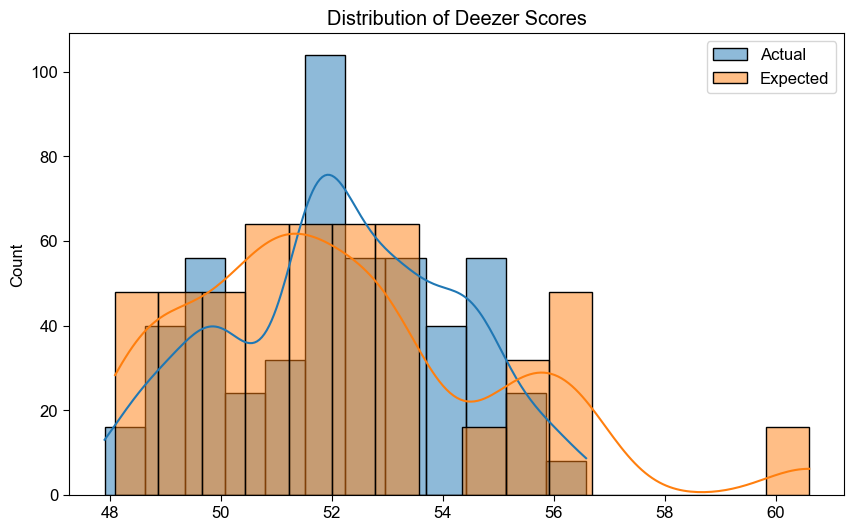


Statistical tests for iTunes:
T-test: t-statistic = nan, p-value = nan
95% CI for actual: (nan, nan)
95% CI for expected: (49.34814442687706, 49.72060557312296)
Variance of actual: nan
Variance of expected: 4.5916
Kolmogorov-Smirnov test: statistic = nan, p-value = nan


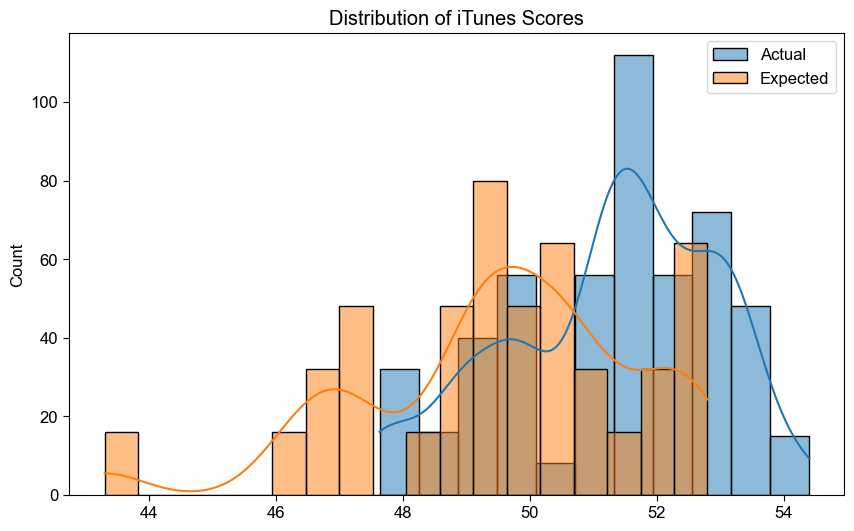

In [15]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


def statistical_tests(actual_scores, expected_scores, score_type):
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(actual_scores, expected_scores)
    
    # Calculate confidence intervals
    ci_actual = stats.t.interval(confidence=0.95, df=len(actual_scores)-1, loc=np.mean(actual_scores), scale=stats.sem(actual_scores))
    ci_expected = stats.t.interval(confidence=0.95, df=len(expected_scores)-1, loc=np.mean(expected_scores), scale=stats.sem(expected_scores))
    
    # Calculate variance
    var_actual = np.var(actual_scores)
    var_expected = np.var(expected_scores)
    
    # Perform Kolmogorov-Smirnov test
    ks_stat, ks_p_value = stats.ks_2samp(actual_scores, expected_scores)
    
    print(f"\nStatistical tests for {score_type}:")
    print(f"T-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    print(f"95% CI for actual: {ci_actual}")
    print(f"95% CI for expected: {ci_expected}")
    print(f"Variance of actual: {var_actual:.4f}")
    print(f"Variance of expected: {var_expected:.4f}")
    print(f"Kolmogorov-Smirnov test: statistic = {ks_stat:.4f}, p-value = {ks_p_value:.4f}")
    
    # Visualize distributions
    plt.figure(figsize=(10, 6))
    sns.histplot(actual_scores, kde=True, label='Actual')
    sns.histplot(expected_scores, kde=True, label='Expected')
    plt.title(f'Distribution of {score_type} Scores')
    plt.legend()
    plt.show()


actual_scores_deezer = []
expected_scores_deezer = []
actual_scores_itunes = []
expected_scores_itunes = []

for alpha_ent in [0.30, 0.40]:
    for alpha_word in [0.2, 0.3, 0.4, 0.5]:
        for k in [20, 50, 100, 200]:
            expected_row = expected[(expected["alpha_ent"] == alpha_ent) & (expected["alpha_word"] == alpha_word) & (expected["k"] == k)]
            
            expected_score_deezer = expected_row["score_deezer"].values[0]
            expected_score_itunes = expected_row["score_itunes"].values[0]
            
            for n_topics in [10, 20, 50, 100]:
                for n_neighbours in [5, 10, 20, 500]:
                    actual_row = actual[(actual["alpha_ent"] == alpha_ent) & (actual["alpha_word"] == alpha_word) & 
                                        (actual["k"] == k) & (actual["n_topics"] == n_topics) & 
                                        (actual["n_neighbours"] == n_neighbours)]
                    
                    if not actual_row.empty:
                        actual_score_deezer = actual_row["score_deezer"].values[0]
                        actual_score_itunes = actual_row["score_itunes"].values[0]
                        
                        actual_scores_deezer.append(actual_score_deezer)
                        expected_scores_deezer.append(expected_score_deezer)
                        actual_scores_itunes.append(actual_score_itunes)
                        expected_scores_itunes.append(expected_score_itunes)

# Perform statistical tests for Deezer scores
statistical_tests(actual_scores_deezer, expected_scores_deezer, "Deezer")

# Perform statistical tests for iTunes scores
statistical_tests(actual_scores_itunes, expected_scores_itunes, "iTunes")


In [31]:
import scipy.stats as stats
import numpy as np

def perform_reproducibility_tests(actual_scores, expected_scores, metric_name, confidence_level=0.95):
    """
    Perform statistical tests to analyze reproducibility of results
    
    Parameters:
    actual_scores, expected_scores: arrays of scores to compare
    metric_name: string identifier for the metric being tested
    confidence_level: confidence level for intervals (default 0.95)
    """
    # T-test for comparing means
    t_stat, p_value = stats.ttest_ind(actual_scores, expected_scores)
    
    # Confidence intervals
    n_actual = len(actual_scores)
    mean_actual = np.mean(actual_scores)
    sem_actual = stats.sem(actual_scores)
    ci_actual = stats.t.interval(confidence_level, n_actual-1, 
                                loc=mean_actual, scale=sem_actual)
    
    n_expected = len(expected_scores)
    mean_expected = np.mean(expected_scores)
    sem_expected = stats.sem(expected_scores)
    ci_expected = stats.t.interval(confidence_level, n_expected-1, 
                                 loc=mean_expected, scale=sem_expected)
    
    # Variances
    var_actual = np.var(actual_scores, ddof=1)
    var_expected = np.var(expected_scores, ddof=1)
    
    # Kolmogorov-Smirnov test for distribution comparison
    ks_stat, ks_p = stats.ks_2samp(actual_scores, expected_scores)
    
    print(f"\nResults for {metric_name}:")
    print(f"T-test: statistic={t_stat:.4f}, p-value={p_value:.4f}")
    print(f"Confidence intervals ({confidence_level*100}%):")
    print(f"  Actual: ({ci_actual[0]:.4f}, {ci_actual[1]:.4f})")
    print(f"  Expected: ({ci_expected[0]:.4f}, {ci_expected[1]:.4f})")
    print(f"Variances:")
    print(f"  Actual: {var_actual:.6f}")
    print(f"  Expected: {var_expected:.6f}")
    print(f"KS-test: statistic={ks_stat:.4f}, p-value={ks_p:.4f}")

# Modify your existing loop to collect scores
actual_deezer_scores = []
actual_itunes_scores = []
expected_deezer_scores = []
expected_itunes_scores = []

for alpha_ent in [0.30, 0.40]:
    for alpha_word in [0.2, 0.3, 0.4, 0.5]:
        for k in [20, 50, 100, 200]:
            expected_row = expected[(expected["alpha_ent"] == alpha_ent) & 
                                  (expected["alpha_word"] == alpha_word) & 
                                  (expected["k"] == k)]
            
            expected_score_deezer = expected_row["score_deezer"].values[0]
            expected_score_itunes = expected_row["score_itunes"].values[0]
            
            for n_topics in [10, 20, 50, 100]:
                for n_neighbours in [5, 10, 20, 500]:
                    actual_row = actual[(actual["alpha_ent"] == alpha_ent) & 
                                      (actual["alpha_word"] == alpha_word) & 
                                      (actual["k"] == k) & 
                                      (actual["n_topics"] == n_topics) & 
                                      (actual["n_neighbours"] == n_neighbours)]
                    
                    actual_score_deezer = actual_row["score_deezer"].values[0]
                    actual_score_itunes = actual_row["score_itunes"].values[0]
                    
                    if np.isnan(actual_score_deezer) or np.isnan(actual_score_itunes):
                        continue

                    actual_deezer_scores.append(actual_score_deezer)
                    actual_itunes_scores.append(actual_score_itunes)
                    expected_deezer_scores.append(expected_score_deezer)
                    expected_itunes_scores.append(expected_score_itunes)

# Perform statistical tests
perform_reproducibility_tests(actual_deezer_scores, expected_deezer_scores, "Deezer Scores")
perform_reproducibility_tests(actual_itunes_scores, expected_itunes_scores, "iTunes Scores")

# Add these checks after collecting scores
print("iTunes Scores Statistics:")
print(f"Actual scores count: {len(actual_itunes_scores)}")
print(f"Non-null actual scores: {sum(~np.isnan(actual_itunes_scores))}")
print(f"Sample of actual scores: {actual_itunes_scores[:5]}")



Results for Deezer Scores:
T-test: statistic=0.2283, p-value=0.8194
Confidence intervals (95.0%):
  Actual: (51.9947, 52.3533)
  Expected: (51.8943, 52.3832)
Variances:
  Actual: 4.255413
  Expected: 7.909005
KS-test: statistic=0.2035, p-value=0.0000

Results for iTunes Scores:
T-test: statistic=14.4127, p-value=0.0000
Confidence intervals (95.0%):
  Actual: (51.1179, 51.4063)
  Expected: (49.3459, 49.7190)
Variances:
  Actual: 2.751468
  Expected: 4.607805
KS-test: statistic=0.4521, p-value=0.0000
iTunes Scores Statistics:
Actual scores count: 511
Non-null actual scores: 511
Sample of actual scores: [51.6682, 51.369600000000005, 51.4062, 51.432599999999994, 52.913999999999994]


In [32]:
import scipy.stats as stats
import numpy as np
import pandas as pd

def perform_statistical_analysis(actual_scores, expected_scores, metric_name):
    results = {}
    
    # Convert inputs to numpy arrays
    actual_scores = np.array(actual_scores)
    expected_scores = np.array(expected_scores)
    
    # T-test comparing two independent samples
    t_stat, p_value = stats.ttest_ind(actual_scores, expected_scores)
    
    # Calculate confidence intervals
    actual_ci = stats.t.interval(
        0.95,
        len(actual_scores)-1,
        loc=np.mean(actual_scores),
        scale=stats.sem(actual_scores)
    )
    
    expected_ci = stats.t.interval(
        0.95,
        len(expected_scores)-1,
        loc=np.mean(expected_scores),
        scale=stats.sem(expected_scores)
    )
    
    # Calculate variances
    actual_var = np.var(actual_scores)
    expected_var = np.var(expected_scores)
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_pvalue = stats.ks_2samp(actual_scores, expected_scores)
    
    results = {
        't_test': {'statistic': t_stat, 'p_value': p_value},
        'confidence_intervals': {
            'actual': actual_ci,
            'expected': expected_ci
        },
        'variance': {
            'actual': actual_var,
            'expected': expected_var
        },
        'ks_test': {'statistic': ks_stat, 'p_value': ks_pvalue}
    }
    
    return results

# Collect scores
actual_scores_deezer = []
actual_scores_itunes = []
expected_scores_deezer = []
expected_scores_itunes = []

for alpha_ent in [0.30, 0.40]:
    for alpha_word in [0.2, 0.3, 0.4, 0.5]:
        for k in [20, 50, 100, 200]:
            expected_row = expected[
                (expected["alpha_ent"] == alpha_ent) & 
                (expected["alpha_word"] == alpha_word) & 
                (expected["k"] == k)
            ]
            
            expected_score_deezer = expected_row["score_deezer"].values[0]
            expected_score_itunes = expected_row["score_itunes"].values[0]
            
            for n_topics in [10, 20, 50, 100]:
                for n_neighbours in [5, 10, 20, 500]:
                    actual_row = actual[
                        (actual["alpha_ent"] == alpha_ent) & 
                        (actual["alpha_word"] == alpha_word) & 
                        (actual["k"] == k) & 
                        (actual["n_topics"] == n_topics) & 
                        (actual["n_neighbours"] == n_neighbours)
                    ]
                                        
                    if np.isnan(actual_score_deezer) or np.isnan(actual_score_itunes):
                        continue

                    if len(actual_row) > 0:  # Check if row exists
                        actual_scores_deezer.append(actual_row["score_deezer"].values[0])
                        actual_scores_itunes.append(actual_row["score_itunes"].values[0])
                        expected_scores_deezer.append(expected_score_deezer)
                        expected_scores_itunes.append(expected_score_itunes)

# Perform analysis
for dataset, actual_scores, expected_scores in [
    ('Deezer', actual_scores_deezer, expected_scores_deezer),
    ('iTunes', actual_scores_itunes, expected_scores_itunes)
]:
    if len(actual_scores) > 0:  # Only perform analysis if we have data
        results = perform_statistical_analysis(actual_scores, expected_scores, dataset)
        
        print(f"\nStatistical tests for {dataset}:")
        print(f"T-test: t-statistic = {results['t_test']['statistic']:.4f}, "
              f"p-value = {results['t_test']['p_value']:.4f}")
        print(f"95% CI for actual: {results['confidence_intervals']['actual']}")
        print(f"95% CI for expected: {results['confidence_intervals']['expected']}")
        print(f"Variance of actual: {results['variance']['actual']:.4f}")
        print(f"Variance of expected: {results['variance']['expected']:.4f}")
        print(f"Kolmogorov-Smirnov test: statistic = {results['ks_test']['statistic']:.4f}, "
              f"p-value = {results['ks_test']['p_value']:.4f}")



Statistical tests for Deezer:
T-test: t-statistic = 0.2059, p-value = 0.8369
95% CI for actual: (51.99947938115035, 52.357814368849645)
95% CI for expected: (51.902415489742154, 52.391334510257835)
Variance of actual: 4.2499
Variance of expected: 7.9119
Kolmogorov-Smirnov test: statistic = 0.2031, p-value = 0.0000

Statistical tests for iTunes:
T-test: t-statistic = nan, p-value = nan
95% CI for actual: (nan, nan)
95% CI for expected: (49.34814442687706, 49.72060557312296)
Variance of actual: nan
Variance of expected: 4.5916
Kolmogorov-Smirnov test: statistic = nan, p-value = nan
